In [ ]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')    
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

**Загрузка датасета и предобработка данных**

In [ ]:
df = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data3/SpotifyFeatures.csv')
df

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


В данных убираются дубликаты: одни и те же композиции, которые записаны под разными жанрами

In [ ]:
df = df.drop_duplicates(subset = ['artist_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'track_name'])

In [ ]:
# размер очищенных данных
df.shape

(191056, 18)

In [ ]:
#сброс индексов
df.reset_index(drop= True , inplace= True )

Решение задачи многоклассовой классификации: столбец-таргет popularity закодируем от 1 до 5 по графику распределения

Text(0.5, 1.0, 'Распределение популярности')

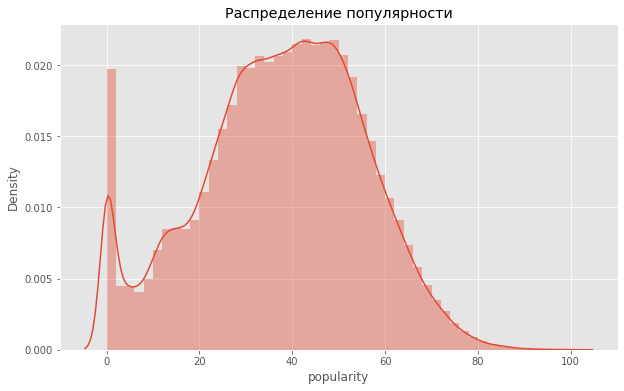

In [ ]:
fig = plt.figure(figsize = (10, 6))
sns.distplot(df.popularity).set_title('Распределение популярности')

In [ ]:
df.loc[df['popularity'] < 10, 'popularity'] = 1
df.loc[(df['popularity'] >= 10) & (df['popularity'] < 35), 'popularity'] = 2
df.loc[(df['popularity'] >= 35) & (df['popularity'] < 55), 'popularity'] = 3
df.loc[(df['popularity'] >= 55) & (df['popularity'] < 75), 'popularity'] = 4
df.loc[(df['popularity'] >= 75) & (df['popularity'] <= 100), 'popularity'] = 5

In [ ]:
df.popularity.value_counts()

3    79672
2    64591
4    30476
1    14449
5     1868
Name: popularity, dtype: int64

Выбор необходимых для построения модели колонок

In [ ]:
features = ['genre','acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']

Для категориальных столбцов 'genre', 'key', 'time_signature' применяется LeaveOneOutEncoder, бинарный столбец 'mode' кодируется с помощью OneHotEncoder.

In [ ]:
cat_cols = ['genre', 'key', 'time_signature']

In [ ]:
y_train = df['popularity']
X_train = df[features]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 420)

**Применение моделей**

Логистическая регрессия

In [ ]:
pipe_model = Pipeline([
    ('one_hot_encoder', OneHotEncoder(cols='mode')),
    ('leave_one_out_encoder', LeaveOneOutEncoder(cols = cat_cols)),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression())
])

params = {'model__C' : np.arange(0.0001, 10.0001, 1),
          'model__class_weight' : [None, 'balanced']}

gs = GridSearchCV(pipe_model,params, cv=3, scoring='f1_micro', verbose=2)

gs.fit(X_train, y_train)

gs.best_score_, gs.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........model__C=0.0001, model__class_weight=None; total time=   2.7s
[CV] END ..........model__C=0.0001, model__class_weight=None; total time=   3.5s
[CV] END ..........model__C=0.0001, model__class_weight=None; total time=   4.0s
[CV] END ......model__C=0.0001, model__class_weight=balanced; total time=   2.4s
[CV] END ......model__C=0.0001, model__class_weight=balanced; total time=   2.2s
[CV] END ......model__C=0.0001, model__class_weight=balanced; total time=   2.2s
[CV] END ..........model__C=1.0001, model__class_weight=None; total time=   7.5s
[CV] END ..........model__C=1.0001, model__class_weight=None; total time=   7.6s
[CV] END ..........model__C=1.0001, model__class_weight=None; total time=   7.9s
[CV] END ......model__C=1.0001, model__class_weight=balanced; total time=   7.9s
[CV] END ......model__C=1.0001, model__class_weight=balanced; total time=   7.5s
[CV] END ......model__C=1.0001, model__class_wei

(0.6410471255206223,
 Pipeline(steps=[('one_hot_encoder', OneHotEncoder(cols=['mode'])),
                 ('leave_one_out_encoder',
                  LeaveOneOutEncoder(cols=['genre', 'key', 'time_signature'])),
                 ('scaler', MinMaxScaler()),
                 ('model', LogisticRegression(C=5.0001))]))

In [ ]:
model_LR = gs.best_estimator_

model_LR.fit(X_train, y_train)

pred_LR = model_LR.predict(X_test)

f1_score(y_test,pred_LR,average='micro')

0.6401765619275258

RandomForestClassifier

In [ ]:
pipe_model_RFC = Pipeline([
    ('one_hot_encoder', OneHotEncoder(cols='mode')),
    ('leave_one_out_encoder', LeaveOneOutEncoder(cols = cat_cols)),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

params = {'model__max_features': ['sqrt', 'log2']}

gs = GridSearchCV(pipe_model_RFC, params, cv=3, scoring='f1_micro', verbose=2)

gs.fit(X_train, y_train)

gs.best_score_, gs.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ...........................model__max_features=sqrt; total time=  17.1s
[CV] END ...........................model__max_features=sqrt; total time=  16.6s
[CV] END ...........................model__max_features=sqrt; total time=  16.4s
[CV] END ...........................model__max_features=log2; total time=  17.7s
[CV] END ...........................model__max_features=log2; total time=  17.3s
[CV] END ...........................model__max_features=log2; total time=  15.6s


(0.485370780372919,
 Pipeline(steps=[('one_hot_encoder', OneHotEncoder(cols=['mode'])),
                 ('leave_one_out_encoder',
                  LeaveOneOutEncoder(cols=['genre', 'key', 'time_signature'])),
                 ('scaler', MinMaxScaler()),
                 ('model', RandomForestClassifier(max_features='sqrt'))]))

In [ ]:
model_RFC = gs.best_estimator_

model_RFC.fit(X_train, y_train)

pred_RFC = model_RFC.predict(X_test)

f1_score(y_test,pred_RFC,average='micro')

0.4900814766997575

KNeighborsClassifier

In [ ]:
pipe_model_KNN = Pipeline([
    ('one_hot_encoder', OneHotEncoder(cols='mode')),
    ('leave_one_out_encoder', LeaveOneOutEncoder(cols = cat_cols)),
    ('scaler', MinMaxScaler()),
    ('model', KNeighborsClassifier())
])


params = {'model__algorithm': ['ball_tree', 'kd_tree','auto']}

gs = GridSearchCV(pipe_model_KNN, params, cv=3, scoring='f1_micro', verbose=2)

gs.fit(X_train, y_train)

gs.best_score_, gs.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........................model__algorithm=ball_tree; total time=  43.0s
[CV] END .........................model__algorithm=ball_tree; total time=  39.4s
[CV] END .........................model__algorithm=ball_tree; total time=  43.0s
[CV] END ...........................model__algorithm=kd_tree; total time=  17.4s
[CV] END ...........................model__algorithm=kd_tree; total time=  15.9s
[CV] END ...........................model__algorithm=kd_tree; total time=  16.0s
[CV] END ..............................model__algorithm=auto; total time=  16.7s
[CV] END ..............................model__algorithm=auto; total time=  15.6s
[CV] END ..............................model__algorithm=auto; total time=  16.0s


(0.597237895246569,
 Pipeline(steps=[('one_hot_encoder', OneHotEncoder(cols=['mode'])),
                 ('leave_one_out_encoder',
                  LeaveOneOutEncoder(cols=['genre', 'key', 'time_signature'])),
                 ('scaler', MinMaxScaler()),
                 ('model', KNeighborsClassifier(algorithm='ball_tree'))]))

In [ ]:
model_KNN = gs.best_estimator_

model_KNN.fit(X_train, y_train)

pred_KNN = model_KNN.predict(X_test)

f1_score(y_test,pred_KNN, average='micro')

0.6036603450983129

DecisionTreeClassifier

In [ ]:
pipe_model_DTC = Pipeline([
    ('one_hot_encoder', OneHotEncoder(cols='mode')),
    ('leave_one_out_encoder', LeaveOneOutEncoder(cols = cat_cols)),
    ('scaler', MinMaxScaler()),
    ('model', DecisionTreeClassifier())
])


params = {'model__splitter': ['best', 'random']}

gs = GridSearchCV(pipe_model_DTC, params, cv=3, scoring='f1_micro', verbose=2)

gs.fit(X_train, y_train)

gs.best_score_, gs.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ...............................model__splitter=best; total time=   0.8s
[CV] END ...............................model__splitter=best; total time=   0.8s
[CV] END ...............................model__splitter=best; total time=   0.8s
[CV] END .............................model__splitter=random; total time=   0.7s
[CV] END .............................model__splitter=random; total time=   0.7s
[CV] END .............................model__splitter=random; total time=   0.6s


(0.5595001251476968,
 Pipeline(steps=[('one_hot_encoder', OneHotEncoder(cols=['mode'])),
                 ('leave_one_out_encoder',
                  LeaveOneOutEncoder(cols=['genre', 'key', 'time_signature'])),
                 ('scaler', MinMaxScaler()),
                 ('model', DecisionTreeClassifier(splitter='random'))]))

In [ ]:
model_DTC = gs.best_estimator_

model_DTC.fit(X_train, y_train)

pred_DTC = model_DTC.predict(X_test)

f1_score(y_test,pred_DTC, average='micro')

0.604218643683375

 SVM

In [ ]:
pipe_model_SVC = Pipeline([
    ('one_hot_encoder', OneHotEncoder(cols='mode')),
    ('leave_one_out_encoder', LeaveOneOutEncoder(cols = cat_cols)),
    ('scaler', MinMaxScaler()),
    ('model', SVC())
])


pipe_model_SVC.fit(X_train, y_train)

pred_SVC = pipe_model_SVC.predict(X_test)

f1_score(y_test,pred_SVC,average='micro')

0.6510808311670185

лучший результат получился у модели SVM с ошибкой 0,65

### Content Based Cosine Similarity 

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

In [ ]:
df = df.sample(10000)
df.reset_index(drop= True , inplace= True )

In [ ]:
#кодируем категориальные столбцы key, mode, time_signature
list_of_keys = df['key'].unique()
for i in range(len(list_of_keys)):
  df.loc[df.key == list_of_keys[i], 'key'] = i

df.loc[df['mode']== 'Major', 'mode'] = 1
df.loc[df['mode']== 'Minor', 'mode'] = 0

list_of_time_signatures = df['time_signature'].unique()
for i in range(len(list_of_time_signatures)):
  df.loc[df['time_signature'] == list_of_time_signatures[i], 'time_signature'] = i

In [ ]:
feature_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence',]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_df =scaler.fit_transform(df[feature_cols])

print(normalized_df[:2])

[[2.69052369e-02 6.10771915e-01 2.60260439e-02 8.80849513e-01
  4.97482377e-05 0.00000000e+00 2.27023737e-01 9.07487617e-01
  1.00000000e+00 3.92652368e-01 6.34757628e-01 0.00000000e+00
  4.72081218e-01]
 [1.84736950e-01 5.24640209e-01 4.05370181e-02 6.28530834e-01
  0.00000000e+00 9.09090909e-02 7.16169608e-02 8.55097092e-01
  1.00000000e+00 8.91909110e-03 5.92061815e-01 0.00000000e+00
  4.99492386e-01]]


In [ ]:
indices = pd.Series(df.index, index=df['track_name']).drop_duplicates()

cosine = cosine_similarity(normalized_df)

In [ ]:
def generate_recommendation(track_name, model_type=cosine):
    """
    Purpose: Function for song recommendations 
    Inputs: song title and type of similarity model
    Output: Pandas series of recommended songs
    """
    
    idx=indices[track_name]

    sim_scores=list(enumerate(model_type[idx]))

    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)

    sim_scores = sim_scores[1:11]

    songs_indices = [i[0] for i in sim_scores]
  
    return df['track_name'].iloc[songs_indices]

In [ ]:
generate_recommendation('Every Scar Has a Story',cosine)

1861                            Caribbean Girl (Raw)
8207                                    La Bicicleta
3654                                  Vibra Positiva
318                                Games People Play
2871                                      Kryptonite
5488                                       La Celosa
9188    Sigue Viajando (Remix) [feat. Alexis y Zion]
4028                                          Family
9471                                  Mi Mejor Amiga
4313                                  Asado y Fernet
Name: track_name, dtype: object